# Very simple Normalizing Flows in Torch

## Target distribution to sample from

We will sample from a mixture of 2D Gaussians. The target distribution is defined as follows:

$$
p(x_1, x_2) = N(x_1|\frac{1}{4x_2^2}, 1) \cdot N(x_2|0,4)
$$

In [ ]:
import numpy as np
import torch
from torch import nn

# target distribution implementation from https://github.com/VincentStimper/normalizing-flows/tree/master

class Target(nn.Module):
    """
    Sample target distributions to test models
    """

    def __init__(self, prop_scale=torch.tensor(6.0), prop_shift=torch.tensor(-3.0)):
        """Constructor

        Args:
          prop_scale: Scale for the uniform proposal
          prop_shift: Shift for the uniform proposal
        """
        super().__init__()
        self.register_buffer("prop_scale", prop_scale)
        self.register_buffer("prop_shift", prop_shift)

    def log_prob(self, z):
        """
        Args:
          z: value or batch of latent variable

        Returns:
          log probability of the distribution for z
        """
        raise NotImplementedError("The log probability is not implemented yet.")

    def rejection_sampling(self, num_steps=1):
        """Perform rejection sampling on image distribution

        Args:
          num_steps: Number of rejection sampling steps to perform

        Returns:
          Accepted samples
        """
        eps = torch.rand(
            (num_steps, self.n_dims),
            dtype=self.prop_scale.dtype,
            device=self.prop_scale.device,
        )
        z_ = self.prop_scale * eps + self.prop_shift
        prob = torch.rand(
            num_steps, dtype=self.prop_scale.dtype, device=self.prop_scale.device
        )
        prob_ = torch.exp(self.log_prob(z_) - self.max_log_prob)
        accept = prob_ > prob
        z = z_[accept, :]
        return z

    def sample(self, num_samples=1):
        """Sample from image distribution through rejection sampling

        Args:
          num_samples: Number of samples to draw

        Returns:
          Samples
        """
        z = torch.zeros(
            (0, self.n_dims), dtype=self.prop_scale.dtype, device=self.prop_scale.device
        )
        while len(z) < num_samples:
            z_ = self.rejection_sampling(num_samples)
            ind = np.min([len(z_), num_samples - len(z)])
            z = torch.cat([z, z_[:ind, :]], 0)
        return z

class TwoMoons(Target):
    """
    Bimodal two-dimensional distribution
    """

    def __init__(self):
        super().__init__()
        self.n_dims = 2
        self.max_log_prob = 0.0

    def log_prob(self, z):
        """
        ```
        log(p) = - 1/2 * ((norm(z) - 2) / 0.2) ** 2
                 + log(  exp(-1/2 * ((z[0] - 2) / 0.3) ** 2)
                       + exp(-1/2 * ((z[0] + 2) / 0.3) ** 2))
        ```

        Args:
          z: value or batch of latent variable

        Returns:
          log probability of the distribution for z
        """
        a = torch.abs(z[:, 0])
        log_prob = (
            -0.5 * ((torch.norm(z, dim=1) - 2) / 0.2) ** 2
            - 0.5 * ((a - 2) / 0.3) ** 2
            + torch.log(1 + torch.exp(-4 * a / 0.09))
        )
        return log_prob


In [ ]:
import matplotlib.pyplot as plt

target = TwoMoons()
z = target.sample(1000)
plt.scatter(z[:, 0], z[:, 1])
plt.show()

In [ ]:
# base dist (multivariate normal diagonal)
base_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

plt.figure()
plt.scatter(base_dist.sample((10000,))[:,0], base_dist.sample((10000,))[:,1])

leaky_relu = nn.LeakyReLU(0.01)

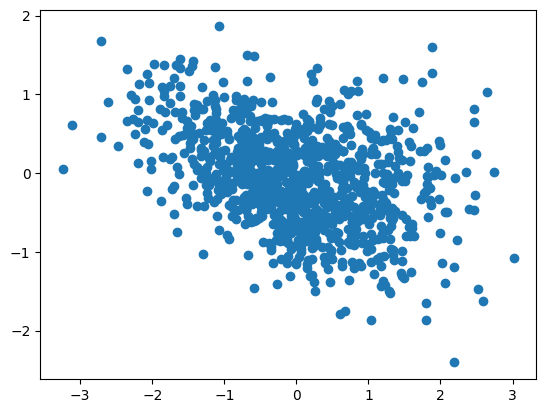

In [110]:
class NormalizingFlow(torch.nn.Module):
    def __init__(self, base_dist, flows):
        super().__init__()
        self.base_dist = base_dist
        self.flows = torch.nn.ModuleList(flows)

    def forward(self, z):
        log_det = torch.zeros(len(z), device=z.device)
        for flow in self.flows:
            z, log_d = flow(z)
            log_det += log_d
        return z, log_det

    def inverse(self, x):
        log_det = torch.zeros(len(x), device=x.device)
        for i in range(len(self.flows) - 1, -1, -1):
            x, log_d = self.flows[i].inverse(x)
            log_det += log_d
        return x, log_det

    def sample(self, num_samples):
        z, log_q = self.base_dist.sample((num_samples,)), torch.zeros(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q

# lower triangular affine transformation + lower rank update M + V * D * V^T
class LowerTriangularAffineCoupling(nn.Module):
    def __init__(self, d, hidden):
        super().__init__()
        self.scale = nn.Sequential(
            nn.Linear(d // 2, hidden),
            leaky_relu,
            nn.Linear(hidden, hidden),
            leaky_relu,
            nn.Linear(hidden, d - d // 2),
            nn.Tanh(),
        )
        self.shift = nn.Sequential(
            nn.Linear(d // 2, hidden),
            leaky_relu,
            nn.Linear(hidden, hidden),
            leaky_relu,
            nn.Linear(hidden, d // 2),
        )

    def forward(self, z):
        z1, z2 = z.chunk(2, dim=1)
        scale = self.scale(z1)
        shift = self.shift(z1)
        z2 = z2 * torch.exp(scale) + shift
        return torch.cat([z1, z2], dim=1), torch.sum(scale, dim=1)

    def inverse(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale(x1)
        shift = self.shift(x1)
        x2 = (x2 - shift) * torch.exp(-scale)
        return torch.cat([x1, x2], dim=1), -torch.sum(scale, dim=1)

class LeakyReLUFlow(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(d))

    def forward(self, z):
        return z * torch.exp(self.alpha), torch.sum(self.alpha)

    def inverse(self, x):
        return x * torch.exp(-self.alpha), -torch.sum(self.alpha)

n_layers = 16

flows = []

for i in range(n_layers):
    flows.append(LowerTriangularAffineCoupling(2, 512))
    flows.append(LeakyReLUFlow(2))

base_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

flows = flows[:-1]

model = NormalizingFlow(base_dist, flows)

z, log_q = model.sample(1000)
plt.figure()
plt.scatter(z.detach()[:, 0], z.detach()[:, 1])

In [111]:
# training

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in range(500):
    z, log_q = model.sample(1000)
    log_p = target.log_prob(z)
    loss = torch.mean(log_q - log_p)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print("Epoch", i, "Loss", loss.item())
    if i % 100 == 0:
        print(loss.item())

Epoch 0 Loss 27.209394454956055
27.209394454956055
Epoch 10 Loss 16.77290153503418
Epoch 20 Loss 15.956419944763184
Epoch 30 Loss 15.391950607299805
Epoch 40 Loss 14.759062767028809
Epoch 50 Loss 13.613563537597656
Epoch 60 Loss 13.502792358398438
Epoch 70 Loss 12.841856002807617
Epoch 80 Loss 12.132648468017578
Epoch 90 Loss 12.34227466583252
Epoch 100 Loss 11.971732139587402
11.971732139587402
Epoch 110 Loss 11.389915466308594
Epoch 120 Loss 11.292359352111816
Epoch 130 Loss 11.63388442993164
Epoch 140 Loss 11.176480293273926
Epoch 150 Loss 11.261608123779297
Epoch 160 Loss 11.067452430725098
Epoch 170 Loss 11.59104061126709
Epoch 180 Loss 11.675993919372559
Epoch 190 Loss 11.553399085998535
Epoch 200 Loss 10.919628143310547
10.919628143310547
Epoch 210 Loss 11.264102935791016
Epoch 220 Loss 10.745750427246094
Epoch 230 Loss 10.827348709106445
Epoch 240 Loss 11.054376602172852
Epoch 250 Loss 10.893194198608398
Epoch 260 Loss 10.598793029785156
Epoch 270 Loss 11.18249225616455
Epoch 2

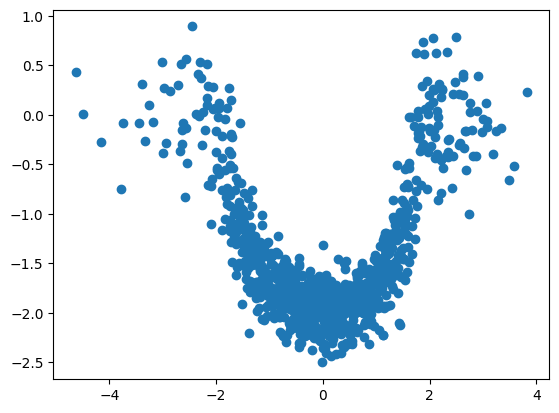

In [112]:
# plotting transformed base distribution

z, log_q = model.sample(1000)
plt.figure()
plt.scatter(z.detach()[:, 0], z.detach()[:, 1])